## Fine tune a HuBERT model

We construct a label classifying by adding two fully-connected layers on top
of a pretrained HuBERT feature extraction network. We train the two added layers
on ReCANVo data, then we unfreeze the HuBERT extraction layer and train further.

In [2]:
from copy import deepcopy
import os
from pathlib import Path
import random
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import tqdm
import torch
from torch import nn
import torchaudio
from torcheval.metrics.functional import multiclass_f1_score

helper_dir = Path(os.getcwd()).parent / "helpers"
sys.path.append(str(helper_dir))
from helpers import get_hubert_features, unweighted_f1

In [3]:
class Model(nn.Module):
    """
    Neural network using pre-trained HuBERT model with additional layers
    """

    def __init__(self, hubert_model, additional_model):
        super().__init__()
        self.hubert_model = hubert_model
        self.additional_model = additional_model

    def forward(self, X, features=False):
        """
        If features is True, treat X as input to self.additional_model.
        Otherwise, treat X as a raw waveform and extract HuBERT features first.
        """
        if not features:
            X = self.hubert_features(X)
        pred = self.additional_model(X)

        return pred

    def hubert_features(self, waveform):
        if waveform.ndim == 3 and waveform.shape[0] == 1:
            waveform = waveform.squeeze(0)
        x = self.hubert_model.extract_features(waveform, num_layers=1)[0]
        return x[0].mean((0, 1)).unsqueeze(0)

    def freeze_hubert(self):
        for param in self.hubert_model.parameters():
            param.requires_grad = False

    def unfreeze_hubert(self):
        for param in self.hubert_model.parameters():
            param.requires_grad = True

In [4]:
# Get HuBERT features for one participant
hubert_features = get_hubert_features("P05")
label_list = hubert_features["label_list"]
X_tr = hubert_features["X_tr"]
y_tr = hubert_features["y_tr"]
X_te = hubert_features["X_te"]

  0%|          | 0/981 [00:00<?, ?it/s]

## Fine tune HuBERT model

First, we freeze HuBERT, train the remaining layers until out-of-sample performance
is maximized. Then, we unfreeze the HuBERT layer, and train for an additional epoch,
using a smaller learning rate.

  0%|          | 0/300 [00:00<?, ?it/s]

/home/jr/miniconda3/envs/ml_311/lib/python3.11/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/home/jr/miniconda3/envs/ml_311/lib/python3.11/site-packages/torch/autograd/graph.py:744: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


0.6201506 122


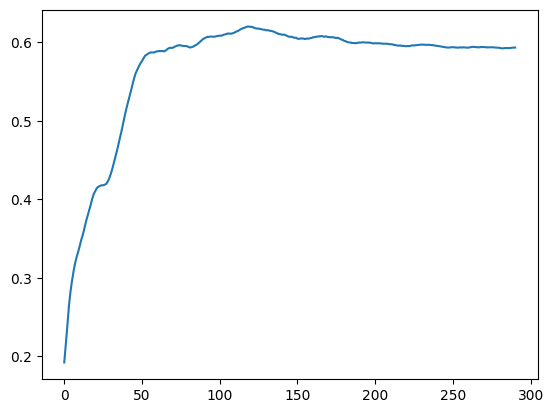

In [5]:
np.random.seed(12345)
test_folds = np.random.randint(0, 10, len(X_tr))

hidden_size = 16
torch.manual_seed(12345)
additional_model = nn.Sequential(
    nn.Linear(768, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, len(label_list)),
    nn.Softmax(),
)
base_model = Model(
    torchaudio.pipelines.HUBERT_BASE.get_model(), additional_model
)
model_dict = {}
opt_dict = {}
for test_fold in np.unique(test_folds):
    model = deepcopy(base_model)
    opt = torch.optim.AdamW(model.parameters(), lr=1e-2)
    model_dict[test_fold] = model
    opt_dict[test_fold] = opt

scores = []
for n in tqdm(range(300)):
    pred = torch.zeros(len(X_tr), len(label_list))
    for fold, model in model_dict.items():
        opt = opt_dict[fold]
        mask = test_folds == fold
        loss = nn.NLLLoss()(
            model(X_tr[~mask], features=True).log(), y_tr[~mask]
        )
        opt.zero_grad()
        loss.backward()
        opt.step()
        with torch.no_grad():
            pred[mask] = model(X_tr[mask], features=True)
    score = multiclass_f1_score(
        pred, y_tr, average="macro", num_classes=len(label_list)
    )
    scores.append(score)
scores = np.array(scores)
smoothed_scores = sum(scores[n : -9 + n] for n in range(9)) / 9
print(np.max(smoothed_scores), np.argmax(smoothed_scores) + 4)
plt.plot(smoothed_scores)
plt.show()

In [16]:
np.random.seed(12345)
test_folds = np.random.randint(0, 10, len(X_tr))

hidden_size = 16
torch.manual_seed(12345)
additional_model = nn.Sequential(
    nn.Linear(768, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, len(label_list)),
    nn.Softmax(),
)
base_model = Model(
    torchaudio.pipelines.HUBERT_BASE.get_model(), additional_model
)
model_dict = {}
opt_dict = {}
for test_fold in np.unique(test_folds):
    model = deepcopy(base_model)
    opt = torch.optim.AdamW(model.parameters(), lr=1e-2)
    model_dict[test_fold] = model
    opt_dict[test_fold] = opt

# Train network
for n in tqdm(range(123)):
    for fold, model in model_dict.items():
        opt = opt_dict[fold]
        mask = test_folds == fold
        loss = nn.NLLLoss()(
            model(X_tr[~mask], features=True).log(), y_tr[~mask]
        )
        opt.zero_grad()
        loss.backward()
        opt.step()

# Check performance (should be very similar to previous cell)
pred = torch.zeros(len(X_tr), len(label_list))
for fold, model in model_dict.items():
    opt = opt_dict[fold]
    mask = test_folds == fold
    loss = nn.NLLLoss()(model(X_tr[~mask], features=True).log(), y_tr[~mask])
    opt.zero_grad()
    loss.backward()
    opt.step()
    with torch.no_grad():
        pred[mask] = model(X_tr[mask], features=True)
score = multiclass_f1_score(
    pred, y_tr, average="macro", num_classes=len(label_list)
)
print(score)

  0%|          | 0/123 [00:00<?, ?it/s]

/home/jr/miniconda3/envs/ml_311/lib/python3.11/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


tensor(0.6192)


In [9]:
waveforms_tr = hubert_features["waveforms_tr"]
session_tr = hubert_features["session_tr"]

In [18]:
# Unfreeze the HuBERT model and fine tune. We iterate through samples, and
# monitor out-of-sample performance every 100 samples.
for session, model in model_dict.items():
    opt = torch.optim.AdamW(model.parameters(), lr=7e-7)
    model.unfreeze_hubert()
    opt_dict[session] = opt

to_iterate = list(zip(waveforms_tr, test_folds, y_tr))
random.shuffle(to_iterate)

for count, (waveform, test_fold, yy) in tqdm(enumerate(to_iterate)):
    for other_fold, model in model_dict.items():
        if other_fold == test_fold:
            continue
        model = model_dict[other_fold]
        opt = opt_dict[other_fold]
        loss = nn.NLLLoss()(model(waveform).log(), yy.unsqueeze(0))

        # We make a (very small) update after every sample. Batching waveforms
        # is difficult because they have different shapes.
        opt.zero_grad()
        loss.backward()
        opt.step()

    if (count + 1) % 50 == 0:
        with torch.no_grad():
            preds = []
            for waveform, fold in zip(waveforms_tr, test_folds):
                model = model_dict[fold]
                preds.append(model(waveform))
        preds = torch.tensor(np.array([p[0].numpy() for p in preds]))
        print(
            "Score:",
            multiclass_f1_score(
                preds, y_tr, average="macro", num_classes=len(label_list)
            ),
        )

0it [00:00, ?it/s]

/home/jr/miniconda3/envs/ml_311/lib/python3.11/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Score: tensor(0.5957)


KeyboardInterrupt: 

In [15]:
print(
    "Score:",
    multiclass_f1_score(
        preds, y_tr, average="macro", num_classes=len(label_list)
    ),
)

Score: tensor(0.6075)
